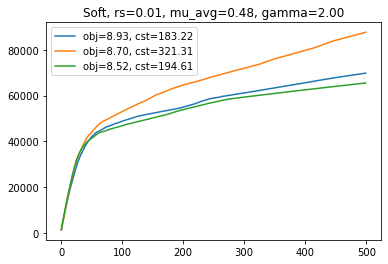

In [1]:
from functions import *


seed = 1
N = 3  # number of experiments
T = 500  # rounds per experiment
gamma = 2
rs = 0.01
alpha = 1

np.random.seed(seed)

m = 20 # number of devices
n = 15  # number of servers
y_max = 120
y_min = 80

alpha = 1
beta = np.ones(n)


wD = np.random.randint(1 ,4 ,m )
wS = np.random.randint(1 ,4 ,n )

BD = np.random.uniform(y_max * 0.1-3, y_max * 0.1+5, m)
BS = np.random.uniform(y_max * m / n - 100, y_max * m / n + 300, n)

CD = np.random.uniform(100, 200, m)


def f(x, y, mu, gamma=1):
    return objective(x, y, mu, wD, wS, m, n, gamma, alpha, BD, BS, CD=None)

# min f(x, y. mu)
def oracle(y, mu, gamma=0, hard=False):
    x, prob = optimization(m, n, wD, wS, y, mu, BD, BS, gamma, hard, alpha)
    return x.value, prob.value, prob.status


reg = np.zeros((N, T))

# statistics
stats = np.zeros((N, T, 3))

#records all y, x_opt, x_t #yuhang yao
y_N_T = np.zeros((N, T, m)) #yuhang yao
x_opt_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
x_t_N_T = np.zeros((N, T, n + 1, m)) #yuhang yao
j_N_T = np.zeros((N, T, m))#yuhang yao

for u in range(N):
    # mu = np.random.rand(m, n)/4 + 0.75
    # fast_link = np.random.choice(n, m)
    # for i in range(m):
    #     mu[i, fast_link[i]] *= 0.02

    # trace_gen = Trace(m, n, seed + u)
    # mu = trace_gen.avg()

    mu = np.random.rand(m, n)
    # mu = trace_gen.avg()
    mu_hat = np.zeros_like(mu)  # empirical mean
    T_ij = np.ones_like(mu)  # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(y_min, y_max, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu, gamma)

        if 'optimal' not in status:
            print('Solution infeasible 1')
            break

        fv, *_, dv, ev = f(x_opt, y, mu, gamma)
        stats[u, t] = np.array([fv, dv, ev])

        rho_ij = np.sqrt(3 * np.log(t + 1) / (2 * T_ij)) * rs
        mu_bar = np.clip(mu_hat - rho_ij, 0, None)  # LCB

        x_t, f_t, status = oracle(y, mu_bar, gamma)
        if 'optimal' not in status:
            print('Solution infeasible')
            break
        f_t, *_ = f(x_t, y, mu, gamma)

        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        # c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n + 1, p=x_t[:, i])
            j_N_T[u, t, i] = j #yuhang yao
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i, j])
                # a = np.random.rand() * 3
                # c_ij = np.random.beta(a, a * (1-mu[i, j])/mu[i, j]) # beta distribution
                # c_ij = c[i,j] #trace

                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt
        
        y_N_T[u, t] = y#yuhang yao
        x_opt_N_T[u, t] = x_opt#yuhang yao
        x_t_N_T[u, t] = x_t#yuhang yao
        

plt.plot(np.cumsum(reg, axis=1).T)
f_avg = np.average(stats[:,:,0], 1)
obj_avg = np.average(stats[:,:,1], 1)
cons_avg = np.average(stats[:,:,2], 1)
legend = []
for i in range(N):
    legend.append('obj=%.2f, cst=%.2f' %(obj_avg[i], cons_avg[i]))
plt.legend(legend)
plt.title('Soft, rs=%.2f, mu_avg=%.2f, gamma=%.2f' %(rs, np.average(mu), gamma))
plt.show()


j_N_T = j_N_T.astype(int)





In [2]:
np.save("soft_wD", wD)
np.save("soft_wS", wS)

np.save("soft_y_N_T", y_N_T)
np.save("soft_x_opt_N_T", x_opt_N_T)
np.save("soft_x_t_N_T", x_t_N_T)
np.save("soft_j_N_T", j_N_T)

In [3]:
from functions import *
wD = np.load("soft_wD.npy")
wS = np.load("soft_wS.npy")
y_N_T = np.load("soft_y_N_T.npy")
x_opt_N_T = np.load("soft_x_opt_N_T.npy")
x_t_N_T = np.load("soft_x_t_N_T.npy")
j_N_T = np.load("soft_j_N_T.npy")


In [4]:
seed = 1
N = 3  # number of experiments
T = 500  # rounds per experiment
gamma = 2
rs = 0.01
alpha = 1

np.random.seed(seed)

m = 20 # number of devices
n = 15  # number of servers
y_max = 120
y_min = 80

In [ ]:
Data_num_D_N_T = np.zeros((N, T, wD.shape[0]))
Data_num_S_N_T = np.zeros((N, T, wS.shape[0]))
for u in range(N):
    for t in range(T):
        Data_num_S_N_T[u, t] = wS
        Data_num_D_N_T[u, t] = wD
        for i in range(m):
            
                    j = j_N_T[u, t, i]#np.random.choice(n + 1, p=x_t_N_T[u, t, :, i])
                    
                    if j != 0:
                        j -= 1
                        Data_num_S_N_T[u, t, j] += y_N_T[u, t, i] #upload to device j-1
                    else:
                        Data_num_D_N_T[u, t, i] += y_N_T[u, t, i] #stay in local device

In [ ]:
from fed_train import fed_T
import time
save_time = str(time.time())
import torch
torch.manual_seed(seed)

total_loss_train = []
total_acc_train_final = 0
total_loss_train_final = 0
total_acc_test = 0
total_loss_test = 0

for u in range(N):
    L_T = []
    for t in range(T):
        L = list(Data_num_D_N_T[u, t]) + list(Data_num_S_N_T[u, t])
        L_T.append(L)
    L_T = np.array(L_T).astype(int)



    loss_train, acc_train_final, loss_train_final, acc_test, loss_test, args = fed_T(L_T, "mnist", True)
    if len(total_loss_train) == 0:
        total_loss_train = np.array(loss_train)
    else:
        total_loss_train += np.array(loss_train)
    
    total_acc_train_final += acc_train_final
    total_loss_train_final += loss_train_final
    total_acc_test += acc_test
    total_loss_test += loss_test
    
total_loss_train /= N
total_acc_train_final /= N
total_loss_train_final /= N
total_acc_test /= N
total_loss_test /= N


plt.figure()
plt.plot(range(len(total_loss_train)), total_loss_train)
plt.ylabel('train_loss')
plt.savefig('./save/' + save_time + 'fed_{}_{}_{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.iid))

print(total_acc_train_final, total_loss_train_final, total_acc_test, total_loss_test)

In [ ]:
args.iid

In [ ]:
args